# Analysis of UNI/WETH transcational data on Uniswap

### Author : George M Cherian

## Part 1 : TheGraph Queries to extract data (GraphQL requests)

In [1]:
# Import the necessary modules to run GraphQL so that TheGraph queries can be used.
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

In [2]:
# Setting the medium across which requests/data is to be sent/received
medium = RequestsHTTPTransport(
url='https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2',
verify=True,
retries=5
)

In [3]:
client = Client(transport=medium)


### Query 1 : To find the id for 'UNI'

In [4]:
query = gql('''
query
{
  tokens( where : {symbol : "UNI"}, first : 3)
  {
    name
    symbol
    id
  }
    
}
''')

In [5]:
response = client.execute(query)
# The symbol 'UNI' is used by multiple currencies
# The 2nd currency is selected...
for item in response['tokens']:
    for key in item:
        print(key + ' : ' + item[key])

id : 0x0478d05f4960fa5c7880a6346a5dd10d894e87ef
name : UNISWAP V2
symbol : UNI
id : 0x1f9840a85d5af5bf1d1762f925bdaddc4201f984
name : Uniswap
symbol : UNI
id : 0x24382731129c7b77cf1fb744e509e32572fa4a45
name : uniswap
symbol : UNI


### Query 2 : To find the id for 'WETH'

In [6]:
query = gql('''
query
{
  tokens( where : {symbol : "WETH"}, first : 3)
  {
    name
    symbol
    id
  }
    
}
''')

In [7]:
response = client.execute(query)
# The symbol 'WETH' is used by multiple currencies
# The 2nd currency is selected..
for item in response['tokens']:
    for key in item:
        print(key + ' : ' + item[key])

id : 0x477b466750c31c890db3208816d60c8585be7f0e
name : Wrapped Ether
symbol : WETH
id : 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
name : Wrapped Ether
symbol : WETH
id : 0xd73d6d4c463df976399acd80ea338384e247c64b
name : Wrapped Ether
symbol : WETH


### Query 3 : To find the id of the pair 'UNI/WETH'

In [8]:
query = gql('''
query{pairs (where: {token0:"0x1f9840a85d5af5bf1d1762f925bdaddc4201f984",token1:"0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"})
  {
    id 
    token0{
      name
      symbol
    }
    token1 
    {
      name
      symbol
    }
  }
}
''')

In [9]:
response = client.execute(query)
print(response)

{'pairs': [{'id': '0xd3d2e2692501a5c9ca623199d38826e513033a17', 'token0': {'name': 'Uniswap', 'symbol': 'UNI'}, 'token1': {'name': 'Wrapped Ether', 'symbol': 'WETH'}}]}


### Query 4 : To get trade date for all 'UNI/WETH' swaps

In [10]:
query = gql('''
query trades{
  swaps(where:{pair: "0xd3d2e2692501a5c9ca623199d38826e513033a17"}, orderBy: timestamp, orderDirection: desc) {
    timestamp
    amount0In
    amount1In
    amount0Out
    amount1Out
    amountUSD
    pair {
      token0 {
        id
        symbol
      }
      token1 {
        id
        symbol
      }
      
      volumeUSD
      totalSupply
      reserveETH
      id
    }
    
    
  }
}
''')

In [11]:
response = client.execute(query)
# Output below shows the data corresponding to 1st entry in the trade response returned.
print(response['swaps'][0])

{'amount0In': '0', 'amount0Out': '3.370790294808753749', 'amount1In': '0.03', 'amount1Out': '0', 'amountUSD': '52.68591856019236315874150824421532', 'pair': {'id': '0xd3d2e2692501a5c9ca623199d38826e513033a17', 'reserveETH': '40730.974103221142795346', 'token0': {'id': '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', 'symbol': 'UNI'}, 'token1': {'id': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'symbol': 'WETH'}, 'totalSupply': '104572.663979439792852798', 'volumeUSD': '6647658171.858585449462365589131271'}, 'timestamp': '1624742202'}


#### Information is extracted and stored in lists. These lists will be used later to populate the dataframe

In [12]:
Timestamp=[]
Side=[]
BCQT=[]
QCQT=[]
Volume=[]
Liquidity=[]
ID=[]

for item in response["swaps"]:
    
    
    Timestamp.append(item["timestamp"])
    Volume.append(float(item['pair']["volumeUSD"]))
    ID.append(item["pair"]["id"])
    Liquidity.append(float(item["pair"]["reserveETH"]))
    
    
    if(item["amount0In"]=='0'):
        Side.append("SELL")
        BCQT.append(float(item["amount0Out"]))
        QCQT.append(float(item["amount1In"]))
    else:
        Side.append("BUY")
        BCQT.append(float(item["amount0In"]))
        QCQT.append(float(item["amount1Out"]))
        
    

## Part 2 : Dataframe Creation and Data Analysis

In [13]:
#importing the required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
%matplotlib inline

### Dataframe Creation

In [15]:
df = pd.DataFrame()
df['Timestamp'] = Timestamp
df['Side'] = Side
df['Base Currency Quantity Traded'] = BCQT
df['Quote Currency Quantity Traded'] = QCQT
df['Volume in USD'] = Volume
df['Liquidity in Pool'] = Liquidity
df['Pool ID'] = ID

In [16]:
ts = pd.to_datetime(df['Timestamp'], unit = 's')
df['Timestamp'] = ts

In [17]:
df1 = df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

In [18]:
df1

,Timestamp,Side,Base Currency Quantity Traded,Quote Currency Quantity Traded,Volume in USD,Liquidity in Pool,Pool ID
0,2021-06-26 21:16:42,SELL,3.370790,0.030000,6647658171.858585,40730.974103,0xd3d2e2692501a5c9ca623199d38826e513033a17
1,2021-06-26 21:15:27,BUY,406.184987,3.594015,6647658171.858585,40730.974103,0xd3d2e2692501a5c9ca623199d38826e513033a17
2,2021-06-26 21:11:58,BUY,727.954937,6.444289,6647658171.858585,40730.974103,0xd3d2e2692501a5c9ca623199d38826e513033a17
3,2021-06-26 21:10:14,BUY,1.368000,0.012114,6647658171.858585,40730.974103,0xd3d2e2692501a5c9ca623199d38826e513033a17
4,2021-06-26 21:10:14,BUY,222.081760,1.966814,6647658171.858585,40730.974103,0xd3d2e2692501a5c9ca623199d38826e513033a17
5,2021-06-26 21:08:00,BUY,397.048741,3.517316,6647658171.858585,40730.974103,0xd3d2e2692501a5c9ca623199d38826e513033a17
6,2021-06-26 21:07:20,BUY,198.736416,1.760993,6647658171.858585,40730.974103,0xd3d2e2692501a5c9ca623199d38826e513033a17
7,2021-06-26 21:02:36,SELL,1.682536,0.015000,6647658171.858585,40730.974103,0xd3d2e2692501a5c9ca623199d38826e513033a17
8,2021-06-26 21:02:11,SELL,1.682538,0.015000,6647658171.858585,40730.974103,0xd3d2e2692501a5c9ca623199d38826e513033a17
9,2021-06-26 20:59:29,BUY,414.257622,3.671684,6647658171.858585,40730.974103,0xd3d2e2692501a5c9ca623199d38826e513033a17


### Data Visualization

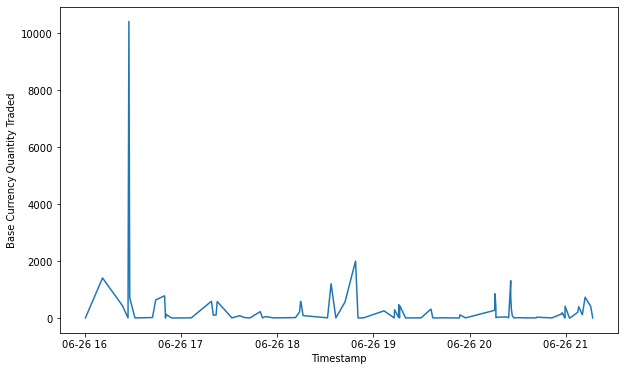

In [19]:
# Line plot showing quantity of base currency traded against time
plt.figure(figsize=(10,6))
sns.lineplot(x=df['Timestamp'],y=df['Base Currency Quantity Traded'],ci=None)

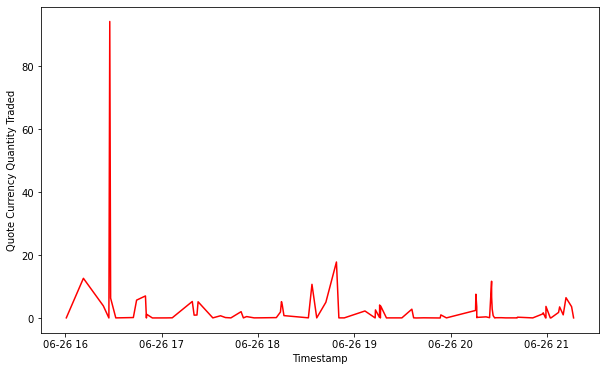

In [20]:
#Line plot showing quantity of quote currency traded against time
plt.figure(figsize=(10,6))
sns.lineplot(x=df['Timestamp'],y=df['Quote Currency Quantity Traded'],ci=None,color='Red')

In [21]:
hr = []
for date_time in df['Timestamp']:
   hr.append(date_time.hour)

In [22]:
df['Hour'] = hr

In [23]:
temp = df.groupby('Side')

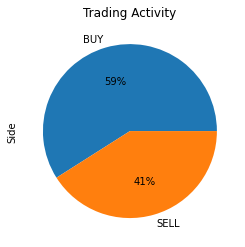

In [24]:
# Pie chart grouping trade as 'BUY' or 'SELL'
temp['Side'].count().plot(kind='pie',title='Trading Activity',autopct='%1.0f%%')

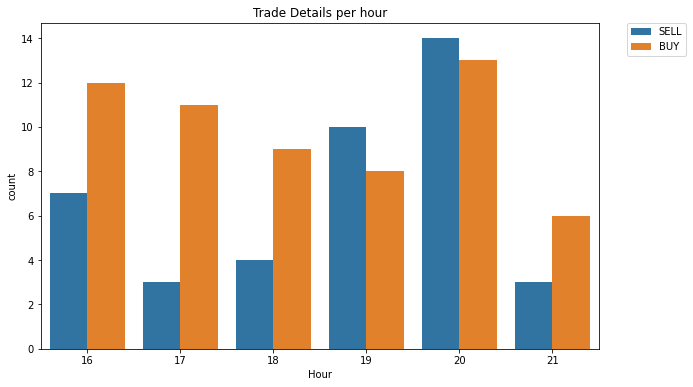

In [25]:
# Trade activity per hour
plt.figure(figsize=(10,6))
pl = sns.countplot(data=df,x='Hour',hue='Side')
pl.set_title('Trade Details per hour')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Text(0.5, 1.0, 'Average Quantity of base currency Bought/Sold')

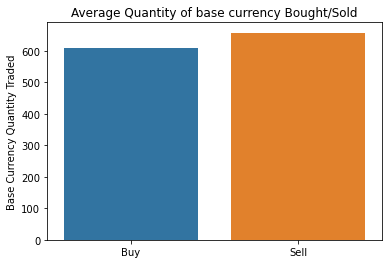

In [26]:
pl = sns.barplot(x=['Buy','Sell'],y=temp['Base Currency Quantity Traded'].mean())
pl.set_title('Average Quantity of base currency Bought/Sold')


Text(0.5, 1.0, 'Average Quantity of quote currency Bought/Sold')

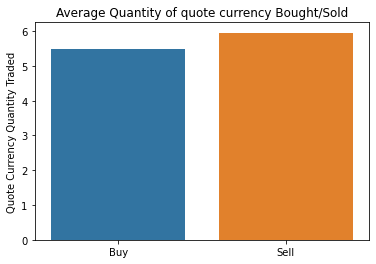

In [27]:
pl = sns.barplot(x=['Buy','Sell'],y=temp['Quote Currency Quantity Traded'].mean())
pl.set_title('Average Quantity of quote currency Bought/Sold')


In [28]:
# INSIGHTS

### Insights from the data

#### 1. A big chunk of the overall transactions (59%) corresponded to users buying the cryptocurrency.
#### 2. For both the base and the quote currencies , the average quantity sold was higher than the quantity bought.
#### 3. As the day progresses an upward trend is seen for selling and a downward trend for buying.